# Семинар 5. Метрическая классификация

В этом занятии мы закрепим пройденный до этого материал, решив реальную практическую задачу - задачу классификации.

**Необходимые импорты:**

In [84]:
import sklearn.datasets as skd
import scipy.stats as sps
import numpy as np

from utils import (
    visualize_comparison,
    visualize_scatter,
    freeze_random_seed,
)

In [85]:
# freeze_random_seed()

## Задача классификации

В общем смысле **классификация** — один из разделов машинного обучения, посвященный решению следующей задачи. Имеется множество объектов, разделённых некоторым образом на классы. Задано конечное множество объектов, для которых известно, к каким классам они относятся. Это множество называется обучающей выборкой. Классовая принадлежность остальных объектов не известна. Требуется построить алгоритм, способный классифицировать произвольный объект из исходного множества.

Более формально задачу можно поставить следующим образом. Пусть $X$ - множество описаний некоторых объектов материального мира, $Y$ - конечное множество меток классов объектов. Каждый объект $x \in X$ относится к какому-либо классу, т.е. каждому объекту $x$ можно поставить в соответствие метку $y \in Y$. Предположим, что в реальном мире существует некоторая зависимость $y$, которая позволяет по описанию объекта установить класс этого объекта: $y^*: X \rightarrow Y$. Значения данной зависимости известно только на ограниченном числе пар вида $X^l = \{(x_1, y_1), ..., (x_l, y_l)\}, x_i \in X, y_i \in Y$. Данное ограниченное множество пар также называется *обучающей выборкой*. Задачей же является построение алгоритма $a$, который бы позволил моделировать исходную зависимость $y^*$ на всем множестве $X$.

Таким образом, наша задача - построение алгоритма $a: X \rightarrow Y$ по полученной обучающей выборке $X^l$. Полученный алгоритм и будет являться алгоритмом классификации.

Однако, прежде чем решать задачу классификации необходимо подготовить данные.

## Часть 1. Подготовка данных

Поскольку рельные данные являются достаточно ценным ресурсом, доступ к которому очень затруднен, мы воспользуемся игрушечным набором данных из модуля `ScikitLearn`.

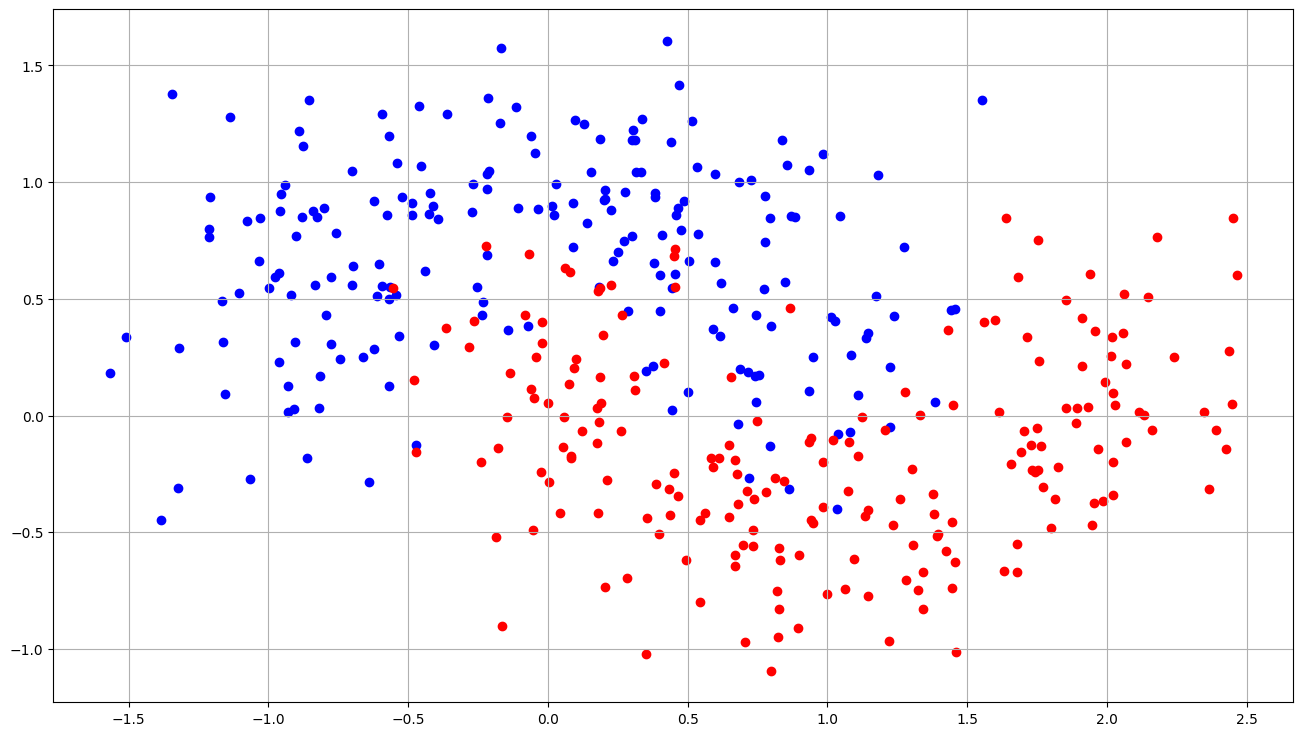

In [86]:
points, labels = skd.make_moons(n_samples=400, noise=0.3)
visualize_scatter(points, labels)

Выше отрисован наш набор данных. Как вы видите, наши данные - это точки плоскости, разделенные на два класса: синие точки и красные точки. Собственно, нашей задачей будет построение алгоритма, который по координатам точки смог бы определять ее цвет.

Стоит отметить, что было бы глупо заниматься построением алгоритма классификации, используя все наши данные. Ведь в этом случае мы лишаем себя возможности корректной оценки качестве полученного алгоритма, о чем мы еще поговорим ниже. Чтобы в будущем оценить качество нашего алгоритма, давайте разделим нашу выборку на две часть: выборку для обучения (*train*) и выборку для тестирования (*test*). Выборку для обучения мы будем использовать для построения нашего алгоритма классификации. Выборку для тестирования - для оценки качества классификации.

Разделение выборки предлагается реализовать через отдельную функцию. На вход функции подаются признаки объектов и значения целевой функции. В нашем случае `points` и `labels`. В зависимости от задачи может возникать необходимость деления выборки на части различных размеров, потому третьим параметром нашей функции будет размер train-части в процентах (в виде числа с плавающей точкой в диапазоне от 0 до 1). На выходе функции необходимо получить 4 массива: два train массива - train_points и train_labels, и два test-массива - test_points и test_labels.

Также важное замечания, соотношения объектов разных классов в полученных train и test частях должно быть равным. Т.е. если в исходном массиве количество синих точек и количество красных точек соотносились в пропорции 2:1, то в test и train частях это соотношение должно сохранится. Это позволит заложить знания о реальном распределении данных в наш алгоритм.

Итак, ваша задача - реализовать функцию для разделения массива на train и test части.

**Важно:** допускается использовать не более одного цикла.

**Совет:** функции `np.unique` и `np.append` могут оказаться полезными.

**Функция:**

In [87]:
class ShapeMismatchError(Exception):
    pass
class NoFitFoundError(Exception):
    pass

In [88]:
def train_test_split(
    features: np.ndarray,
    targets: np.ndarray,
    train_ratio: float = 0.8,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    if (features.shape[0] != targets.shape[0]):
        raise ShapeMismatchError(
            f"Features shape {features.shape[0]} != targets shape {targets.shape[0]}"
            )

    unique_targets, targets_count = np.unique(targets, return_counts=True)
    features_train, features_test, targets_train, targets_test = None, None, None, None

    for  target_index, target in enumerate(unique_targets):
        target_mask = targets == target
        target_features = features[target_mask]

        train_count = int(targets_count[target_index] * train_ratio)

        if features_train is None:
            features_train = target_features[:train_count]
            features_test = target_features[train_count:]
            targets_train = np.full(features_train.shape[0], target)
            targets_test = np.full(features_test.shape[0], target)
        else:
            features_train = np.append(features_train, target_features[:train_count], axis = 0)
            features_test = np.append(features_test, target_features[train_count:], axis = 0)
            targets_train = np.append(targets_train, np.full(train_count, target), axis=0)
            targets_test = np.append(targets_test, np.full(targets_count[target_index] - train_count, target), axis = 0)
 

    return features_train, features_test, targets_train, targets_test

**Тесты:**

In [89]:
points_train, points_test, labels_train, labels_test = train_test_split(
    features=points,
    targets=labels,
    train_ratio=0.8,
)

assert points_train.shape[0] == labels_train.shape[0]
assert points_train.shape[0] == 320
assert points_test.shape[0] == labels_test.shape[0]
assert points_test.shape[0] == 80

for label_part in (labels_test, labels_train):
    _, counts = np.unique(label_part, return_counts=True)
    assert counts[0] == counts[-1]

## Часть 2. Метрическая классификация

Существует множество подходов к построению алгоритмов классификации. Одним из самых простых подходов к классификации является метрический подход. Напомним, что метрикой называется вещественная функция $\rho: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}$, которая удовлетворяет следующим условиям:

- $0 \le \rho(\vec{x}, \vec{y})$
- $\rho(\vec{x}, \vec{y}) = 0 \Leftrightarrow \vec{x} = \vec{y}$
- $\rho(\vec{x}, \vec{y}) = \rho(\vec{y}, \vec{x})$
- $\rho(\vec{x}, \vec{y}) \le \rho(\vec{x}, \vec{z}) + \rho(\vec{z}, \vec{y}), \forall \vec{x}, \vec{y}, \vec{z} \in \mathbb{R}^n$

Условно, метрику можно интерпретировать, как расстояние между точками. Несложно убедиться, что знакомое вам со школы расстояние между точками двумерного пространства подходит под определение метрики. Таким образом в нашем случае $\rho(\vec{x}, \vec{y}) = \sqrt{\sum_{i = 1}^2{(x_i - y_i)^2}}$.

Сам метрический подход основан на следующей гипотезе, которая называется *гипотезой компактности*: если мера сходства объектов введена достаточно удачно, то схожие объекты гораздо чаще лежат в одном классе, чем в разных. В нашем случае мера сходства объектов - это расстояние между объектами, напомним, что наши объекты - это точки двухмерного пространства. Т.е., фактически, метрическая классификация утверждает следующее: чем ближе друг к другу расположены объекты, тем веротянее, что данные объекты принадлежат к одному и тому же классу.

Итак, мы умеем находить расстояние между двумя точками, а на основании гипотезы компактности мы можем сказать, что для определения класса текущей точки нам необходимо найти ближайшую к ней точку с известным классом. В этом и заключается алгоритм метрической классификации.

На практике же определять класс данной точкой по самой ближайшей к ней точки известного класса - непрактичный путь, поскольку он приведет нас к очень шумному и нестабильному результату. Обычно принято смотреть не на одну точку, а на $k$ точек, ближайших к данной. $k$ - это гиперпараметр нашего алгоритма, который обычно пользователь задает сам в зависимости от задачи.

Итак, теперь мы можем сформулировать сам алгоритм. Пусть $X^l$ - наша обучающая выборка, $\vec{x}$ - точка, для которой делается предсказание. Тогда:

- Определим $\Rho = \{ \rho(\vec{x}, \vec{x_i}) | \vec{x_i} \in X^l, i = \overline{1,l} \}$ - множество расстояний от точки $\vec{x}$ до точек обучающей выборки;  
- Упорядочим расстояния по возрастанию: $\rho(\vec{x}, \vec{x_1}) \le ... \le \rho(\vec{x}, \vec{x_l})$;
- Выберем $k$ точек, ближайших в смысле метрики $\rho$ к рассматриваемой точке $\vec{x}$;
- Вычислим величину $label_x = \argmax_{c \in C}{\sum_{i = 1}^k{[y_i = c]}}$, где $C$ - множество классов (в нашем случае множество из двух цветов: красного и синего), $c$ - элемент множества классов, $y_i$ - метка точки $\vec{x_i}$, т.е. цвет точки $\vec{x_i}$, квадратные скобки - функция-индикатор, т.е. функция, которая принимает значение 1, если условие в скобках выполнено, иначе - 0;
- Вычисленная величина $label_x$ и является предсказанием.

![knn](./images/knn.png)

Данный алгоритм носит название **Алгоритм k ближайших соседей** (англ. *k nearest neighbors*), потому что для определения метки объекта нам достаточно посмотреть метки k ближайших к нему объектов и на основании их меток определить искомый класс.

Итак, наша задача реализовать алгоритм в виде класса. Использование циклов запрещено.

**Алгоритм:**

In [90]:
from typing import Union


class KNN:
    _k_neighbours: int
    _points: Union[np.ndarray, None]
    _labels: Union[np.ndarray, None]
    
    def __init__(self, k_neighbours: int = 5) -> None:
        if type(k_neighbours) is int:
            self._k_neighbours = k_neighbours
            self._points, self._labels = None, None
        else:
            raise TypeError("integer type is intended")
        
    def fit(self, points: np.ndarray, labels: np.ndarray) -> None:
        if (points.shape[0] != labels.shape[0] and
        points.shape[0] != 0):
            raise ShapeMismatchError(
                f"Features shape {points.shape[0]} != targets shape {labels.shape[0]}",
                "or it has a shape = 0"
            )
        self._points = points
        self._labels = labels

    def predict(self, points: np.ndarray) -> np.ndarray:

        if (self._points is None) or (self._labels is None):
            raise NoFitFoundError("Predict was called before Fit")

        points_test = np.tile(points,self._points.shape[0])
        points_test -= self._points[:].flatten()
        points_test = points_test**2 
        points_test = points_test.reshape(points.shape[0],self._points.shape[0],2)

        resulted_indeces = np.sum(points_test, axis=2)
        # корень из суммы расстояний до точек я брать не буду, 
        # т.к. это не требуется для нахождения квадрата минимального расстояния, что удовлетворяет условию задачи
        resulted_indeces = np.argsort(resulted_indeces, axis=1)[:, :self._k_neighbours]
        # print(resulted_indeces)
        resulted_indeces = np.sort(resulted_indeces, axis=1)

        labels_knn= np.tile(self._labels[:],self._k_neighbours)
        # print(labels_knn)
        resulted_labels = np.zeros(resulted_indeces.shape[0]*self._k_neighbours)
        resulted_labels =  labels_knn[resulted_indeces.flatten()]
        print(resulted_labels)
        resulted_labels = resulted_labels.reshape(resulted_indeces.shape)
        
        resulted_colour = np.sum(resulted_labels, 1) > self._k_neighbours//2
        print(resulted_colour)
        return resulted_colour

**Тесты:**

[0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[False False False False False  True False False False False  True False
 False False False False False False  True False False False False  True
 False False False False False False False

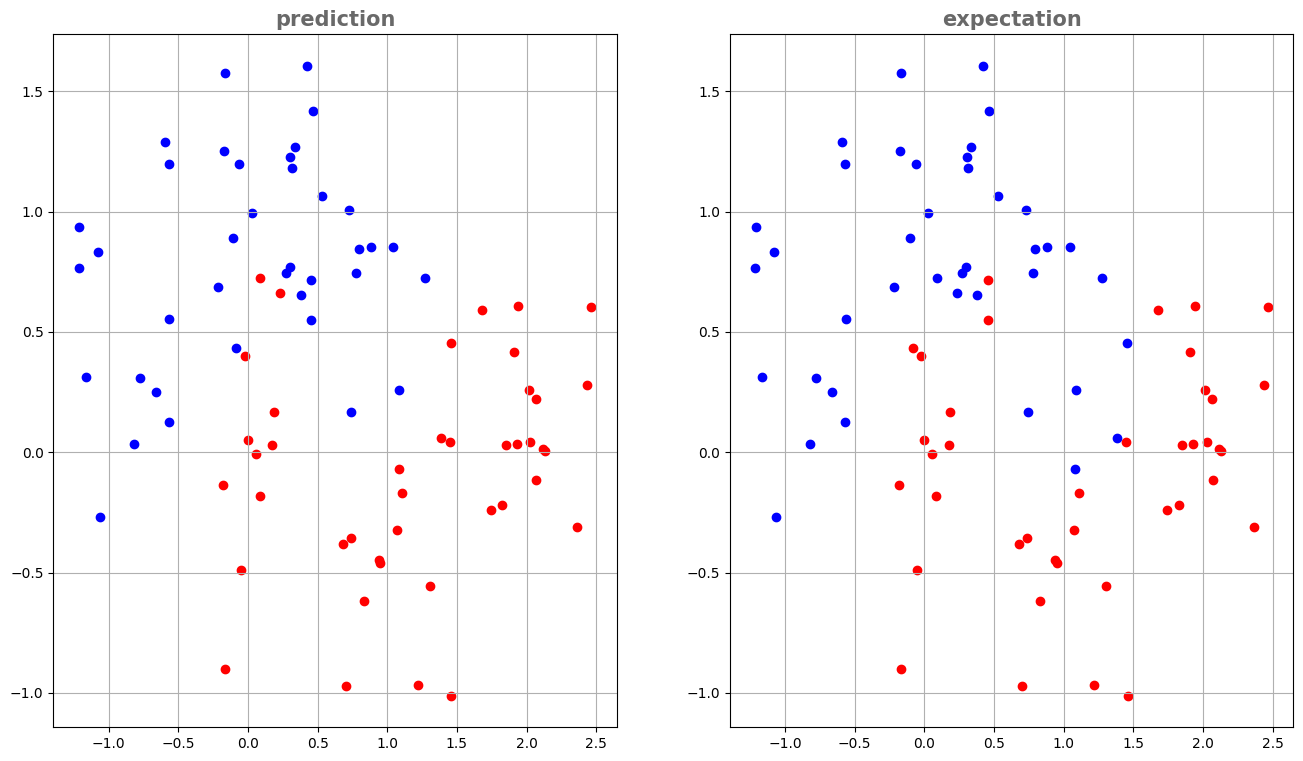

In [91]:
knn = KNN()
knn.fit(points_train, labels_train)
prediction = knn.predict(points_test)

visualize_comparison(points_test, prediction, labels_test)

Визуальный анализ показывает, что алгоритм, в целом, неплохо подходит для решения поставленной задачи классификации и дает неплохие результаты. Однако, не всегда стоит полагаться на данные визуального анализа. Давайте же оценим качество нашей модели в числовом видел с помощью метрики качества.

## Часть 3. Оценка

Метрики качества не имеют никакого отношения к метрике, о которой мы говорили выше. Метрики качества - это функции, которые позволяют оценить качество модели. Каждая метрика качества имеет свой физический смысл и свой диапазон значений. Для каждой задачи существует своя метрика качества. Одной из самых популярных и широко используемых метрик качества применительно к задачам классификации считается метрика *accuracy*. Эта метрика позволяет вычислить отношение числа правильно классифицированных объектов к общему числу объектов. Это можно записать следующим образом:

$$accuracy = \frac{\sum_{i=1}^m{[p_i = y_i]}}{m}, $$

где $m$ - количество объектов, $y_i$ - известный класс объекта, $p_i$ - предсказанный класс объекта.

Из определения метрики видно, что нам необходимо знать классы объектов для оценки качества. Если мы будем оценивать качество работы алгоритма на данных, которые принимали участие в построение алгоритма, показатели качества будут нерепрезантативны. Если выражаться точнее, показатели качества будут завышены, ведь наш алгоритм будет классифицировать те данные, с которыми он работал в прошлом и информация о которых ему известна. Тут-то и приходит на помощь та самая отложенная test-часть нашей выборки, которая не принимала участия в построении алгоритма. Именно на ней и нужно считать показатели качества.

Итак, ваша задача реализовать функцию, вычисляющую метрику $accuracy$.

**Функция:**

In [92]:
def get_accuracy_score(
    prediction: np.ndarray,
    expectation: np.ndarray
) -> float:
    accuracy = np.sum(prediction == expectation)/ expectation.shape[0]
    return accuracy

**Тест:**

In [93]:
accuracy_score = get_accuracy_score(prediction, labels_test)
print(f"knn accuracy: {accuracy_score}")

knn accuracy: 0.9


## Источники:

Вся теоретическая информация и иллюстрации были взяты из следующих источников:

- [Воронцов. Классификация](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F);
- [Yandex ML handbook. Метрические методы](https://education.yandex.ru/handbook/ml/article/metricheskiye-metody);
- [Воронцов. К ближайших соседей](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B1%D0%BB%D0%B8%D0%B6%D0%B0%D0%B9%D1%88%D0%B8%D1%85_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9);